# Project 8 Frequency studies

In [1]:
# Imports
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from scipy.constants import c,e,hbar,k,m_e,e,pi,epsilon_0,m_p,physical_constants

In [2]:
# Constants
m_e_eV = m_e*c**2/e
E_endp_eV = 18600
E_endp = E_endp_eV * e

# Hydrogen 21cm line
h21_0_f = 1420405751.7667
h21_0_ev = 2*pi*h21_0_f*hbar/e
# Bohr magneton
bohr_mag_eV = physical_constants['Bohr magneton in eV/T'][0]  # hbar / (2*m_e)
mu_be_eV = physical_constants['electron mag. mom.'][0]/e
mu_bp_eV = physical_constants['proton mag. mom.'][0]/e
mu_bT_eV = physical_constants['triton mag. mom.'][0]/e

out_dir = './output/'

In [3]:
# definitions
def cres(theta, kin_e, B):
    f_0 = e*B / (2*pi*m_e)
    gamma = 1 + kin_e / m_e_eV
    f = f_0/gamma
    beta2 = 1 - 1/gamma**2
    num = 2*pi*e**2*f_0**2*np.sin(theta)**2*beta2*gamma**2
    denum = 3*epsilon_0*c
    power = num/denum
    return  power, f

# Make a spectrogram for an electron at the end point
def get_time_series(rot_steps,
                    time = 1,             # seconds, should be ms
                    max_rot = 1e12,       # rotations, should be 1e6
                    E_kin_e=E_endp_eV, 
                    theta=pi/2, 
                    tesla=1):
    t_arr = []
    r_arr = []
    f_arr = []
    E_arr = []
    P_arr = []

    t = 0
    r = 0
    E = E_kin_e

    while t < time and r < max_rot:
        power, f = cres(theta, E, tesla)
        dt = rot_steps/f
        t += dt
        r += rot_steps
        E -= power*dt/e
        r_arr.append(r)
        t_arr.append(t)
        f_arr.append(f)
        E_arr.append(E)
        P_arr.append(power)
    
    return np.array(r_arr), np.array(t_arr), np.array(f_arr), np.array(E_arr), np.array(P_arr)

# Hydrogen line calibration using the zeeman formulas.
def zeeman_hydrogen(B_mag, tritium=True):
    if tritium:
        mu_b_eV = mu_bT_eV
    else:
        mu_b_eV = mu_bp_eV

    I = 1/2
    J = 1/2
    II = 2*I+1

    # Feynman
    A = h21_0_ev/(2*II)
    mu1 = -(mu_be_eV/J+mu_b_eV/I)/2
    mu2 = -(mu_be_eV/J-mu_b_eV/I)/2

    eps_a = A+mu1*B_mag
    eps_b = A*(-1+2*np.sqrt(1+mu2**2*B_mag**2/(4*A**2))) 
    eps_c = A-mu1*B_mag
    eps_d = -A*(1+2*np.sqrt(1+mu2**2*B_mag**2/(4*A**2))) 

    # Ramsey III.93, Equivalent, but Ramsey works for different I.
    #levels=[]
    #x = (-mu_be_eV/J+mu_b_eV/I)*B_mag/h21_0_ev
    #for F in [0,1]:
    #    for M in range(-F,F+1,1):
    #        if M==-1 and II==2:
    #            eps = -A - mu_b_eV/I*M*B_mag + (2*F-1)* h21_0_ev/2*(1-x)
    #        else:
    #            eps = -A - mu_b_eV/I*M*B_mag + (2*F-1)* h21_0_ev/2*np.sqrt(1+4*M/II*x + x**2)
    #        levels.append(eps)
            #print(F,M, (2*F-1),np.sign(M+0.5), eps)
    #print('Ramsey', np.array(levels))
    #return np.array(levels)
    #print('Feynman', np.array([eps_d,eps_c,eps_b,eps_a]))
    return np.array([eps_d,eps_c,eps_b,eps_a]) 

def zeeman_hydrogen_f(B_mag):
    return zeeman_hydrogen(B_mag)*e/hbar/(2*pi)

def zeeman_transitions(B_mag):
    freqs = zeeman_hydrogen_f(B_mag)
    ad = freqs[-1]-freqs[0] # pi1
    bc = freqs[2]-freqs[1]  # pi2
    bd = freqs[-1]-freqs[1]  # pi2
    return bc,ad,bd


In [4]:
np.array(zeeman_transitions(1))/1e9
# tritium array([27.33270577, 28.75311152, 27.97953659])
# proton array([27.33270758, 28.75311333, 27.98237395])

array([27.33270577, 28.75311152, 27.97953659])

In [5]:
# variabless
B = 1 
kin_e = E_endp_eV
orbits = 1e6
theta = pi/2

# What is the power radiated by an electron with baseline parameters:
cres(pi/2, E_endp_eV, 1)

(1.1763834382516466e-15, 27009367999.39661)

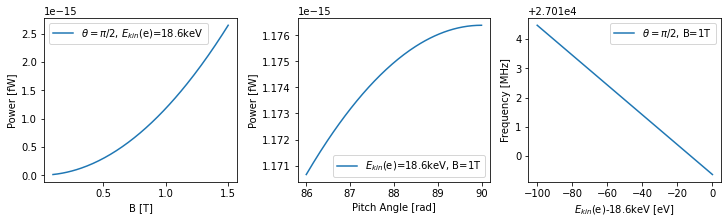

In [6]:
fig, ax = plt.subplots(ncols=3, constrained_layout=True, figsize=(10,3))

# Vary B
B = np.linspace(0.1,1.5,150)
y_data = cres(pi/2, E_endp_eV, B)[0]
ax[0].plot(B,y_data, label = r'$\theta=\pi/2$, $E_{kin}$(e)=18.6keV')
ax[0].set_xlabel('B [T]')

# Vary pitch angle
pitch_angle = np.linspace(86*pi/180,pi/2,150)
y_data = cres(pitch_angle, E_endp_eV, 1)[0]
ax[1].plot(pitch_angle*180/pi,y_data, label = r'$E_{kin}$(e)=18.6keV, B=1T')
ax[1].set_xlabel('Pitch Angle [rad]')

# Vary electron energy
e_kin_E = np.linspace(E_endp_eV-100,E_endp_eV,150)
y_data = cres(pi/2, e_kin_E, 1)[1]
ax[2].plot(e_kin_E-E_endp_eV,y_data/1e6, label = r'$\theta=\pi/2$, B=1T')
ax[2].set_xlabel(r'$E_{kin}$(e)-18.6keV [eV]')

[ax_i.set_ylabel('Power [fW]') for ax_i in ax]
[ax_i.legend() for ax_i in ax]
ax[2].set_ylabel('Frequency [MHz]')

plt.savefig(out_dir + 'power_dep.pdf')

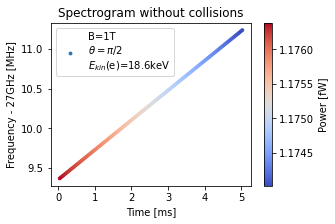

In [7]:
fig, ax = plt.subplots(figsize=(4.5,3))

r_arr, t_arr, f_arr, E_arr, P_arr = get_time_series(1e6, time=5e-3,)
#scaled_z = (P_arr - P_arr.min()) / P_arr.ptp()

sc = ax.scatter(t_arr/1e-3, f_arr/1e6 - 27e3, s=8, c=P_arr/1e-15, cmap = plt.cm.coolwarm, label='B=1T\n'+ r'$\theta=\pi/2$'+'\n'+r'$E_{kin}$(e)=18.6keV')
ax.set_ylabel('Frequency - 27GHz [MHz]')
ax.set_xlabel('Time [ms]')
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Power [fW]')
ax.legend(loc='upper left')
ax.set_title('Spectrogram without collisions')
fig.savefig(out_dir + 'spectrogram.pdf')


In [54]:
# What is the minimum time that a bin should be wide? This is governed by Nyquist and FTT:
deltaE = 0.5 # energy resolution in eV
B_mag = 1 # magnetic field in tesla
deltaF = cres(pi/2, E_endp_eV, B_mag)[1] * deltaE / (E_endp_eV + m_e_eV)
min_time_bin = 1/ (2*deltaF)
print('Nyquist sampling time: {:0.2f} ms'.format(min_time_bin*1e3))

# Same question, but now from a quantum unvertainty point of view:
min_time_bin_qu = 1/ (4*pi*deltaF)
print('Quantum uncertainty boundary on time: {:0.3f} ms'.format(min_time_bin_qu*1e3))
print('number of rotations: {:0.3g}'.format(cres(pi/2, E_endp_eV, B_mag)[1]*min_time_bin))


#Nick: We can make the time shorter: basically you just pad zeros to the end of your data vector, making the total integrated time much longer, lowering the Delta f / frequency bin width


Nyquist sampling time: 0.02 ms
Quantum uncertainty boundary on time: 0.003 ms
number of rotations: 5.3e+05


In [8]:
teslas = np.linspace(0.1,1.5,15)
delta_f = []
f_min = []
delta_f_rot = []

print('Difference in frequency for endpoint electron after 5ms or 1e6 rotations') 
for tesla in teslas:
    _, _, f_arr, _, _ = get_time_series(1e6,time = 5e-3,tesla=tesla)   
    delta_f.append(f_arr.ptp()/1e6)
    f_min.append(f_arr.min()/1e9)

    _, _, f_arr, _, _ = get_time_series(1e4,max_rot= 1e6,tesla=tesla)    
    delta_f_rot.append(f_arr.ptp()/1e6)

    print('B: {:.1f}T \tf: {:.2f}GHz \tdelta_f (5ms): {:.2f}MHz \tdelta_f (1e6 rotations): {:.3f}MHz'.format(tesla, 
                              f_min[-1], 
                              delta_f[-1],
                              delta_f_rot[-1]))


Difference in frequency for endpoint electron after 5ms or 1e6 rotations
B: 0.1T 	f: 2.70GHz 	delta_f (5ms): 0.00MHz 	delta_f (1e6 rotations): 0.000MHz
B: 0.2T 	f: 5.40GHz 	delta_f (5ms): 0.01MHz 	delta_f (1e6 rotations): 0.001MHz
B: 0.3T 	f: 8.10GHz 	delta_f (5ms): 0.05MHz 	delta_f (1e6 rotations): 0.001MHz
B: 0.4T 	f: 10.80GHz 	delta_f (5ms): 0.12MHz 	delta_f (1e6 rotations): 0.002MHz
B: 0.5T 	f: 13.50GHz 	delta_f (5ms): 0.23MHz 	delta_f (1e6 rotations): 0.003MHz
B: 0.6T 	f: 16.21GHz 	delta_f (5ms): 0.40MHz 	delta_f (1e6 rotations): 0.005MHz
B: 0.7T 	f: 18.91GHz 	delta_f (5ms): 0.64MHz 	delta_f (1e6 rotations): 0.007MHz
B: 0.8T 	f: 21.61GHz 	delta_f (5ms): 0.96MHz 	delta_f (1e6 rotations): 0.009MHz
B: 0.9T 	f: 24.31GHz 	delta_f (5ms): 1.36MHz 	delta_f (1e6 rotations): 0.011MHz
B: 1.0T 	f: 27.01GHz 	delta_f (5ms): 1.87MHz 	delta_f (1e6 rotations): 0.014MHz
B: 1.1T 	f: 29.71GHz 	delta_f (5ms): 2.48MHz 	delta_f (1e6 rotations): 0.017MHz
B: 1.2T 	f: 32.41GHz 	delta_f (5ms): 3.23MHz 	delt

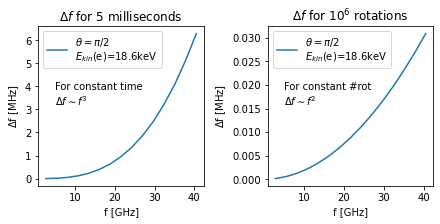

In [9]:
fig, ax = plt.subplots(ncols=2, figsize=(6,3), constrained_layout = True)

ax[0].plot(f_min,delta_f, label=r'$\theta=\pi/2$'+'\n'+r'$E_{kin}$(e)=18.6keV')
#plt.plot(f_min,np.array(f_min)**3/10500) # this fits perfectly
ax[0].set_xlabel('f [GHz]')
ax[0].set_ylabel(r'$\Delta$f [MHz]')
ax[0].set_title(r'$\Delta f$ for 5 milliseconds')
ax[0].legend()
ax[0].text(0.1,0.5,'For constant time\n'+r'$\Delta f \sim f^3$', transform=ax[0].transAxes)

ax[1].plot(f_min,delta_f_rot, label=r'$\theta=\pi/2$'+'\n'+r'$E_{kin}$(e)=18.6keV')
#plt.plot(f_min,np.array(f_min)**3/10500) # this fits perfectly
ax[1].set_xlabel('f [GHz]')
ax[1].set_ylabel(r'$\Delta$f [MHz]')
ax[1].set_title(r'$\Delta f$ for $10^6$ rotations')
ax[1].legend()
ax[1].text(0.1,0.5,'For constant #rot\n'+r'$\Delta f \sim f^2$', transform=ax[1].transAxes)

fig.savefig(out_dir+'bandwidth_dep.pdf')

# Important, you demonstrated that the difference in frequency over a given time of cyclotron motion behaves as the third power of the frequency. 
# This is expected since P~f**2 and df~fdE and therefore df ~ f**3 if time is constant. 
# The difference in frequency for a given number of rotations scales as the secodn power of the frequency. 
# This is expected since dt = rotations/f in combination with the previous statement. 

In [22]:
kr83_17 = 17.8e3
kr83_30 = 30e3
kr83_32 = 32e3
neon = 0.8


e_calib = np.array([E_endp_eV, kr83_17, kr83_30, kr83_32, neon])
c_calib = ['C0','C1','C2','C3','C8']
l_calib = [r'$^{3}$H 18.6keV', 
           r'$^{83m}$Kr 17.8keV',
           r'$^{83m}$Kr 30keV',
           r'$^{83m}$Kr 32keV',
           r'Ne 0.8keV']
alpha_calib = [0.7, 0.5, 0.5, 0.5, 0.5]

zip_calib = list(zip(e_calib,
                     c_calib,
                     l_calib,
                     alpha_calib))

(140, 100)


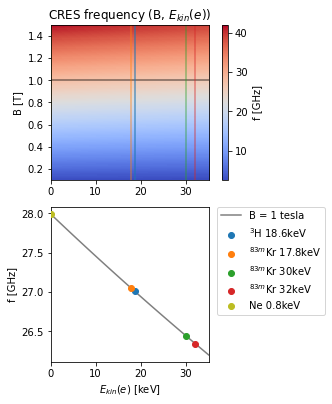

In [23]:
fig, ax = plt.subplots(nrows=2, figsize=(4.5,5.5), constrained_layout=True)

B = np.linspace(0.1,1.5,140)
e_kin_E = np.linspace(0e3,35e3,100)

f_0 = e*B / (2*pi*m_e)
gamma = 1 + e_kin_E / m_e_eV
f = np.outer(f_0,1/gamma)
print(f.shape)
im = ax[0].pcolorfast(e_kin_E/1e3,B,f/1e9, cmap = 'coolwarm')
ax[0].set_ylabel('B [T]')
ax[1].set_xlabel(r'$E_{kin}(e)$ [keV]')
ax[0].set_title(r'CRES frequency (B, $E_{kin}(e)$)')

ax[1].plot(e_kin_E/1e3,cres(pi/2,e_kin_E,1)[1]/1e9, c='k', alpha=0.5,label = 'B = 1 tesla')
ax[0].axhline(y=1, c='k', alpha=0.5)
for e_c, c_c, l_c, a_c in zip_calib:
    ax[0].axvline(x=e_c/1e3, label=l_c, alpha=a_c, c=c_c)
    ax[1].scatter(e_c/1e3, cres(pi/2,e_c,1)[1]/1e9,label=l_c, c=c_c, zorder=3)

clb = plt.colorbar(im, ax=ax[0])
clb.set_label('f [GHz]')
#ax[0].legend(bbox_to_anchor=(1.35, 1), loc='upper left', borderaxespad=0.)

ax[1].set_xlim(e_kin_E.min()/1e3,e_kin_E.max()/1e3)
ax[1].set_ylabel('f [GHz]')
ax[1].set_xlabel(r'$E_{kin}(e)$ [keV]')
ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

fig.savefig(out_dir+'calib_energy.pdf')

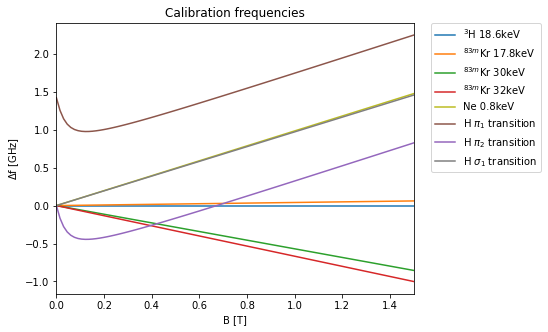

In [24]:
fig, ax = plt.subplots(nrows=1, figsize=(7.5,4.5), constrained_layout=True)

B = np.linspace(0.0,1.5,100)

for e_c, c_c, l_c, a_c in zip_calib:
    ax.plot(B, (cres(pi/2,e_c,B)[1]-cres(pi/2,E_endp_eV,B)[1]) /1e9,label=l_c, c=c_c)

bc, ad, bd = zeeman_transitions(B)-cres(pi/2,E_endp_eV,B)[1]
ax.plot(B,ad/1e9, label=r'H $\pi_1$ transition', c='C5')
ax.plot(B,bc/1e9, label=r'H $\pi_2$ transition', c='C4')
ax.plot(B,bd/1e9, label=r'H $\sigma_1$ transition', c='grey')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
ax.set_xlim(0,1.5)
ax.set_xlabel('B [T]')
ax.set_ylabel(r'$\Delta$f [GHz]')
ax.set_title('Calibration frequencies')

fig.savefig(out_dir+'calib_frequency.pdf')

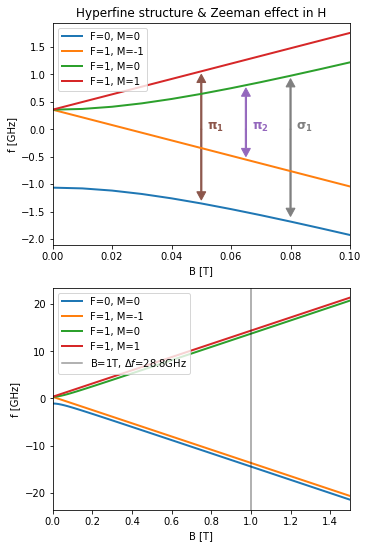

In [13]:
fig, ax = plt.subplots(nrows=2, constrained_layout=True, figsize=(5,7.5))

labels = ['F=0, M=0','F=1, M=-1','F=1, M=0','F=1, M=1']

B_arr = np.linspace(0,0.1,11)
levels = [zeeman_hydrogen_f(B_mag)/1e9 for B_mag in B_arr]
for q_nr, q_l in zip(np.stack(levels).T,labels):
    ax[0].plot(B_arr,q_nr, lw=2, label=q_l)
ax[0].set_ylabel('f [GHz]')
ax[0].set_xlabel('B [T]')
ax[0].set_xlim(B_arr.min(),B_arr.max())
ax[0].set_title('Hyperfine structure & Zeeman effect in H')
ax[0].legend(loc='upper left')

B_arr = np.linspace(0,1.5,100)
levels = [zeeman_hydrogen_f(B_mag)/1e9 for B_mag in B_arr]
for q_nr, q_l in zip(np.stack(levels).T,labels):
    ax[1].plot(B_arr,q_nr, lw=2, label=q_l)
ax[1].set_ylabel('f [GHz]')
ax[1].set_xlabel('B [T]')
ax[1].set_xlim(B_arr.min(),B_arr.max())
ax[1].axvline(x=1, label = r'B=1T, $\Delta f$=28.8GHz',c='k',alpha=0.4)
#ax[1].set_title('Hyperfine structure & Zeeman effect in H')
ax[1].legend(loc='upper left')


ax[0].arrow(x=0.05, y=0, dx=0, dy=0.85, color='C5', width=0.0004, shape='full',head_width=0.003, head_length=0.15)
ax[0].arrow(x=0.05, y=0, dx=0, dy=-1.14, color='C5',width=0.0004, shape='full',head_width=0.003, head_length=0.15)
ax[0].text(x = 0.052, y=0, s=r'$\mathbf{\pi_1}$', c='C5', size=12)

ax[0].arrow(x=0.065, y=0, dx=0, dy=0.6, color='C4', width=0.0004, shape='full',head_width=0.003, head_length=0.15)
ax[0].arrow(x=0.065, y=0, dx=0, dy=-0.35, color='C4',width=0.0004, shape='full',head_width=0.003, head_length=0.15)
ax[0].text(x = 0.067, y=0, s=r'$\mathbf{\pi_2}$', c='C4', size=12)

ax[0].arrow(x=0.08, y=0, dx=0, dy=0.77, color='grey', width=0.0004, shape='full',head_width=0.003, head_length=0.15)
ax[0].arrow(x=0.08, y=0, dx=0, dy=-1.44, color='grey',width=0.0004, shape='full',head_width=0.003, head_length=0.15)
ax[0].text(x = 0.082, y=0, s=r'$\mathbf{\sigma_1}$', c='grey', size=12)

fig.savefig(out_dir+'hydrogen_frequencies.pdf')